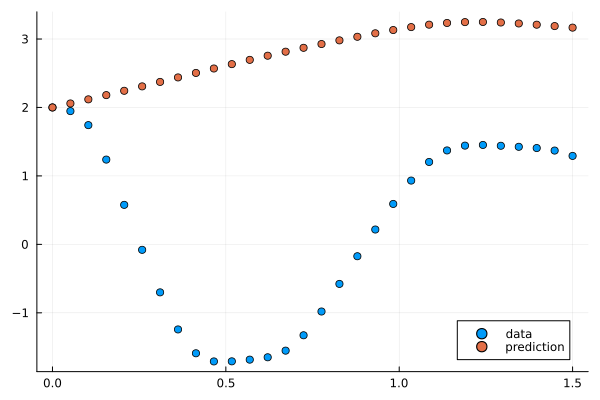

354.43228
354.43228
132.48051
112.57962
112.81752
108.57466
101.96127
98.42128
97.18544
96.1419
94.87688
93.354195
91.65681
89.974495
88.38636
86.69018
84.59695
81.97928
78.89153
75.48101
71.86261
68.077385
63.992805
59.308617
53.75213
47.176178
40.20618
35.004868
34.13967
36.205196
36.84941
29.640839
16.995926
48.75976
16.776152
20.450235
22.77814
26.067892
30.504267
26.424637
27.603504
28.805248
27.878702
25.581017
23.550873
23.101278
23.47224
22.573936
20.481276
18.564304
17.246529
16.023851
14.4095545
12.370023
10.377722
9.884152
12.3356085
11.4667425
8.54631
8.018348
8.391221
8.290073
7.561694
6.7353573
6.245228
6.0914855
5.9172354
5.314186
4.530612
4.204224
4.1881933
4.107981
3.6709
3.3457344
3.141418
2.851192
2.4263656
2.1506214
2.0716996
1.9613482
1.8419893
1.7608443
1.7139885
1.6048512
1.4662845
1.4115721
1.4028714
1.3639995
1.3504356
1.3034003
1.2103019
1.1612731
1.1263009
1.1201487
1.1189141
1.092554
1.0511426
1.0283785
1.0184942
1.0267833
1.0229192
1.0025617
0.9802766
0.964

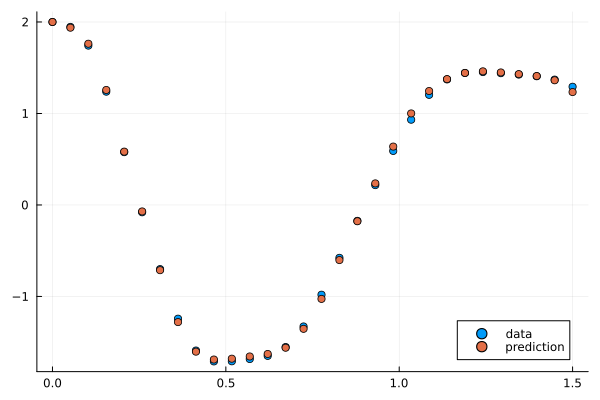

false

In [4]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
    OptimizationOptimisers, Random, Plots

rng = Random.default_rng()
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))

dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

# Do not plot by default for the documentation
# Users should change doplot=true to see the plots callbacks
callback = function (p, l, pred; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...; doplot = true)

# use Optimization.jl to solve the problem
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(optprob, OptimizationOptimisers.Adam(0.05); callback = callback,
    maxiters = 300)

optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(optprob2, Optim.BFGS(; initial_stepnorm = 0.01);
    callback, allow_f_increases = false)

callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)


In [24]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimisers, Random, Plots

In [52]:
rng = Random.default_rng()
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc!(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc!, u0, tspan)
ode_data = solve(prob_trueode, Tsit5();  reltol=1e-2, abstol=1e-2, timeseries_errors=true, tstops=tsteps, save_everystep=true)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 42-element Vector{Float32}:
 0.0
 0.041660886
 0.05172414
 0.09069435
 0.10344828
 0.13727376
 0.15517241
 0.19510752
 0.20689656
 0.25192264
 ⋮
 1.0862069
 1.137931
 1.1896552
 1.2413793
 1.2931035
 1.3448275
 1.3965517
 1.4482758
 1.5
u: 42-element Vector{Vector{Float32}}:
 [2.0, 0.0]
 [1.9617434, 0.64894336]
 [1.9465034, 0.7988315]
 [1.8185569, 1.3238384]
 [1.7417773, 1.4647319]
 [1.4425136, 1.7316623]
 [1.2383387, 1.8087734]
 [0.73052496, 1.865634]
 [0.57711136, 1.8646594]
 [0.0033030272, 1.8402791]
 ⋮
 [1.2032436, -1.3093505]
 [1.3717277, -1.0739127]
 [1.4421114, -0.7771715]
 [1.452477, -0.46015507]
 [1.4404359, -0.14641112]
 [1.4252058, 0.15789185]
 [1.406854, 0.4518799]
 [1.3702354, 0.7292128]
 [1.2920008, 0.97256315]

In [53]:
ode_data.calculate_residuals()

ErrorException: type ODESolution has no field calculate_residuals

In [44]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#46),
        layer_2 = Dense(2 => 50, tanh_fast),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states.

In [45]:
function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

In [46]:
callback = function (p, l, pred; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 8 and 30

In [30]:
# Train using the Adam optimizer
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(optprob,
    OptimizationOptimisers.Adam(0.05);
    callback = callback,
    maxiters = 300)

464.71255
235.21468
199.47995
181.73018
173.6178
170.36714
169.3365
168.66763
168.15836
167.00035
164.61917
162.37744
161.31497
159.34497
157.26279
156.14465
155.7875
155.6492
155.77109
155.92996
155.54224
154.54129
153.35255
152.35587
151.61418
151.24573
151.27467
151.24324
150.93285
150.50993
149.98645
149.275
148.66212
148.3916
148.2055
148.05452
147.74982
147.06764
146.4671
145.86879
145.30544
144.64041
143.50922
142.12233
141.20644
142.07617
145.91983
149.29222
157.25664
140.40457
167.92499
144.45541
146.02031
150.31094
154.05038
156.01398
155.67615
153.65541
150.92444
148.68365
147.98479
148.79865
150.24075
151.38753
151.57515
150.90868
149.90997
148.8136
147.88095
147.4973
147.76794
148.27603
148.44875
148.12923
147.51625
146.89365
146.46533
146.2274
146.13445
146.15108
146.17479
146.01294
145.62192
145.19902
144.89758
144.70901
144.5979
144.47026
144.33395
144.14902
143.86653
143.50948
143.12524
142.764
142.44293
142.20381
141.9392
141.3803
140.90073
140.89355
140.78722
140.393

retcode: Default
u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.59750414 -0.18316548; -0.32736903 0.20581272; … ; 1.2209524 0.134825; -0.19337575 0.7871347], bias = Float32[0.041346107; -0.1807028; … ; -0.20331837; 0.047941312;;]), layer_3 = (weight = Float32[-0.063404076 0.15448481 … -0.85300374 0.41646317; 0.4097688 -0.31561628 … 0.05327413 -0.05806376], bias = Float32[-0.56166106; -0.22892372;;]))

In [40]:
# Retrain using the LBFGS optimizer
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(optprob2,
    Optim.BFGS(; initial_stepnorm = 0.01);
    callback = callback,
    allow_f_increases = false)


133.3881
133.17389
133.17029
133.14584
133.0969
132.87167
132.8338
132.7581
132.70166
132.64813
132.61253
132.56578
132.55444
132.54195
132.5238
132.5131
132.48721
132.43082
131.99158
131.36696
131.30461
131.223
130.91571
130.88123
130.8041
130.74007
130.71904
130.64684
130.51096
130.42218
130.32394
130.08928
129.96054
129.72438
129.52936
129.39977
129.37828
129.33864
129.32664
129.28526
129.22147
128.9581
128.59026
128.48785
128.42749
128.35045
128.2526
128.1944
128.17276
128.16898
128.11717
128.11179
128.08615
128.08617


retcode: Failure
u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.40326086 -0.30216745; -0.20601393 0.24479431; … ; 1.2761806 0.4019975; -0.2786811 1.2274011], bias = Float32[-0.28539154; -0.007836227; … ; -0.06641713; -0.16347386;;]), layer_3 = (weight = Float32[0.24274686 -0.089178 … -1.0535357 0.6631036; 1.1060435 -1.0133069 … -0.17247051 -0.6049927], bias = Float32[-0.6632718; -0.121702746;;]))

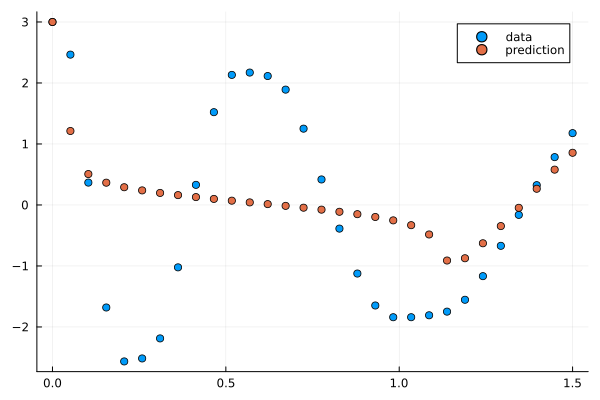

128.08615


false

In [41]:
callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)
